In [1]:
import __init__
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.layers import Concatenate,Embedding ,Dense ,Input,LSTM,Permute,Softmax,Lambda,Flatten,GRU,Dropout,BatchNormalization, Normalization, Attention, Bidirectional, Masking
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import Model
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
root_path = '../../..'
class DataGenerator(Sequence):

    def __init__(self, meta_df, batch_size=64, time_series=30, input_shape=(20,14), use_full=False,**kwargs):
        super().__init__(**kwargs)
        self.ds_pointer = 0
        self.batch_size = batch_size
        self.meta_df = meta_df
        self.time_series = time_series
        self.use_full = use_full
        self.data = self.load_data()
        self.input_buffer = np.zeros((batch_size,input_shape[0],input_shape[1]))
        self.label_buffer = np.zeros(batch_size)
        self.reset_pointer()

    def load_data(self):
        self.meta_df['Label'] = self.meta_df['Label'].astype(int)
        path = self.meta_df['Path']
        temp = {}
        for p in tqdm(path):
           temp[p] = pd.read_csv(f'{root_path}/{p}').to_numpy()
        return temp

    def reset_pointer(self, seed = 1314):
        self.meta_df = self.meta_df.sample(frac=1, random_state=seed)
        self.ds_pointer = 0

    def __len__(self):
      if self.use_full:
        return len(self.meta_df)// self.batch_size
      else:
        return len(self.meta_df)// self.batch_size// 50

    def __getitem__(self, index):
        if self.ds_pointer + self.batch_size >= len(self.meta_df):
            self.reset_pointer()
            return self.__getitem__(index)
        to_get = self.meta_df.iloc[self.ds_pointer:self.ds_pointer+self.batch_size]
        to_get_path = to_get['Path']
        to_get_label = to_get['Label'].to_numpy()

        for i, label in enumerate(to_get_label):
          self.input_buffer[i, :, :] = self.data[to_get_path.iloc[i]][:,:-1]

        batch_x = self.input_buffer
        batch_y = to_get_label

        self.ds_pointer+=self.batch_size

        return batch_x, batch_y

In [3]:
from strategy.CustomStrategies.MA_Strategy_adjustment_short import Strategy_MA_adjust_short
strategy = Strategy_MA_adjust_short
batch_size = 64
input_shape = (20,19)
meta_path = f'{root_path}/ouput/analysis/{strategy.strategy_name}/meta.csv'
meta_df = pd.read_csv(meta_path)

train_meta, test_meta = train_test_split(meta_df)

ModuleNotFoundError: No module named 'script'

In [13]:
train_data = DataGenerator(train_meta, batch_size=batch_size, input_shape=input_shape)
test_data = DataGenerator(test_meta, batch_size=batch_size, input_shape=input_shape, use_full=True)

  0%|          | 0/53663 [00:00<?, ?it/s]

  0%|          | 0/17888 [00:00<?, ?it/s]

In [14]:
test_data.__getitem__(0)

(array([[[-3.58389363e-01, -3.58367972e-01, -3.58410746e-01, ...,
           0.00000000e+00,  2.49945781e+00, -2.31598872e-01],
         [-3.58389363e-01, -3.58378668e-01, -3.58496294e-01, ...,
           0.00000000e+00,  2.49945781e+00, -2.31598872e-01],
         [-3.58378668e-01, -3.58325198e-01, -3.58410746e-01, ...,
           0.00000000e+00,  2.49945781e+00, -2.31598872e-01],
         ...,
         [-3.58186189e-01, -3.58132720e-01, -3.58239659e-01, ...,
           0.00000000e+00,  2.49945781e+00, -2.31598872e-01],
         [-3.58154111e-01, -3.58047180e-01, -3.58154111e-01, ...,
           0.00000000e+00,  2.49945781e+00, -2.31598872e-01],
         [-3.58079258e-01, -3.57993710e-01, -3.58089946e-01, ...,
           0.00000000e+00,  2.49945781e+00, -2.31598872e-01]],
 
        [[ 6.58665697e-01,  6.58879640e-01,  6.57960037e-01, ...,
           0.00000000e+00, -4.25366766e-01, -2.82616470e-01],
         [ 6.57970741e-01,  6.57970741e-01,  6.57970741e-01, ...,
           0.00000000

In [31]:

def build_model(time_series,num_of_features):
    K.clear_session()
    input_ = Input(shape=(time_series,num_of_features), name='Input')
    input_dense = Dense(256)(input_)
    # Define GRU layer
    encoder = GRU(256, return_state=True, return_sequences=True, name='Encoder')
    encoder_outputs, state_h = encoder(input_dense)

    # # Define attention layer
    attention = SeqSelfAttention()(encoder_outputs)

    # Concatenate context vector and encoder outputs
    concat_layer = Concatenate(axis=-1, name='Concatenate')
    decoder_combined_context = concat_layer([attention, input_dense])

    # Define decoder
    decoder_gru = GRU(256, return_sequences=False, name='Decoder')

    # Pass the concatenated input through the decoder
    decoder_output = decoder_gru(decoder_combined_context, initial_state=state_h)

    output = Flatten(name='Flatten')(decoder_output)
    output = Dropout(0.5)(output)
    output = BatchNormalization()(output)
    output = Dense(256,activation="relu")(output)
    output = Dropout(0.5)(output)
    output = BatchNormalization()(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = BatchNormalization()(output)
    output = Dense(1, activation='sigmoid')(output)


    model = Model(inputs = input_ , outputs = output)
    adam_optimizer = Adam(learning_rate=0.001, clipnorm=1., weight_decay=1e-7)
    model.compile(loss="binary_crossentropy",optimizer=adam_optimizer,metrics=['precision'])
    model.summary()
    return model
model = build_model(input_shape[0],input_shape[1])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 20, 13)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20, 256)   │      3,584 │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder (GRU)       │ [(None, 20, 256), │    394,752 │ dense[0][0]       │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_self_attention  │ (None, 20, 256)   │     16,449 │ Encoder[0][0]     │
│ (SeqSelfAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate         │ (None, 20, 512)   │          0 │ seq_self_attenti… │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder (GRU)       │ (None, 256)       │    591,360 │ Concatenate[0][0… │
│                     │                   │            │ Encoder[0][1]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten (Flatten)   │ (None, 256)       │          0 │ Decoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ Flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,107,522 (4.22 MB)

 Trainable params: 1,106,242 (4.22 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [32]:
# Directory Config
neural_path = 'neural_network'
log_path = 'neural_network/log'
save_path_dir='attention_t20_encode_decode'

if not os.path.exists(log_path):
    os.makedirs(log_path)
checkpoint = ModelCheckpoint(
    f'{neural_path}/{save_path_dir}/saved_model.keras',
    verbose=1,
    monitor='val_precision',
    save_weights_only=False,
    save_best_only=True,
    mode='max')

earlystop = EarlyStopping(
    monitor="val_precision",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True
)

!mkdir neural_network

tensorboard = TensorBoard(log_dir=log_path)

�l�ؿ����ɮ� neural_network �w�g�s�b�C


In [9]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

Epoch 1/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.8738 - precision: 0.3832
Epoch 1: val_precision improved from -inf to 0.40081, saving model to neural_network/attention_t20_encode_decode/saved_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 719ms/step - loss: 0.8739 - precision: 0.3840 - val_loss: 0.6971 - val_precision: 0.4008
Epoch 2/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.8647 - precision: 0.4148
Epoch 2: val_precision improved from 0.40081 to 0.40292, saving model to neural_network/attention_t20_encode_decode/saved_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 787ms/step - loss: 0.8647 - precision: 0.4144 - val_loss: 0.6997 - val_precision: 0.4029
Epoch 3/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.8586 - precision: 0.3804
Epoch 3: val_precision improved from 0.40292 to 0.40585, saving model to neural_network/attention_t20_encode_decode/saved_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 722ms/step - loss: 0.8598 - precision: 0.3807 - val_loss: 0.6971

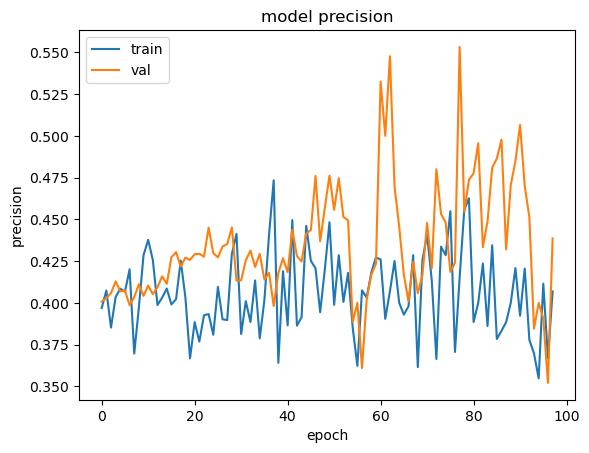

Highest Val Accuracy: 0.5531914830207825


In [33]:
history = model.fit(train_data, batch_size=batch_size, epochs=2000, validation_data=test_data, callbacks=[checkpoint, earlystop, tensorboard])
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print(f"Highest Val Accuracy: {max(history.history['val_precision'])}")